## GPU Info

In [1]:
!nvidia-smi

Tue Dec  6 19:03:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:B2:00.0 Off |                    0 |
| N/A   28C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
import os
import io
import cv2
import glob
import time
import json
import imageio
import colorsys
import multiprocessing as mp
from os import path
from datetime import datetime
from functools import partial

import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format='retina'
from tqdm import tqdm
import geoopt # TODO: use geomstats

from data import sample_2d

## Arguments

In [3]:
class Args:
    def __init__(self):
        self.batch_size = 256
        self.epochs = 10
        self.lr = 3e-3
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dataset = '2spirals' # mnist, 2spirals, checkerboard, rings, 8gaussians
        self.manifold = 'sphere' # sphere, none (euclidean)
        self.size = int(1e6) # dataset size
        self.min_noise = 0.01 # TODO: score can be very large! How do we solve this?
        self.max_noise = 0.1


args = Args()

## Dataset

In [4]:
data_loader_kwargs = dict(shuffle=True, batch_size=args.batch_size, num_workers=4, drop_last=True)

if args.dataset == 'mnist':
    mnist_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
    train_loader = torch.utils.data.DataLoader(mnist_train, **data_loader_kwargs)
else:
    train_loader = torch.utils.data.DataLoader(sample_2d(args.dataset, 100000), **data_loader_kwargs)

## Manifolds

In [11]:
if args.manifold == 'sphere':
    manifold = geoopt.Sphere()

In [12]:
def project_on_sphere(x, r):
    z = torch.sqrt(r ** 2 - x[:, 0] ** 2 - x[:, 1] ** 2)
    return torch.stack((x[:, 0], x[:, 1], z), dim=1) / r

## Noise

In [40]:
# add Gaussian noise to a batch of data points
def add_noise(x, noise_strengths, manifold):
    # if noise_strengths is not a tensor, make it a tensor
    if not isinstance(noise_strengths, torch.Tensor):
        noise_strengths = torch.tensor(noise_strengths, device=x.device)
    noise_strengths = noise_strengths * torch.ones(x.shape[0:1], device=x.device)
    assert x.shape[0:1] == noise_strengths.shape
    B = x.shape[0]
    dim = np.prod(x.shape[1:])
    orig_shape = x.shape
    x = x.view(B, -1)
    noise_strengths = noise_strengths.view(B, 1)
    noise = torch.randn_like(x) * noise_strengths

    if manifold is not None: # NOTE: code is written for the sphere
        noise[:, -1] = 0
        z1 = manifold.origin
#         z1 = torch.zeros(dim, device=x.device)
#         z1[-1] = 1
        noise = sphere.transp([z1], x, noise)
        noisy_x = sphere.expmap(x, noise)
    else:
        noisy_x = x + noise

    return noisy_x.view(orig_shape), noise

In [41]:
# # # get one batch from train_loader
# # for batch_idx, (data, target) in enumerate(train_loader):
# #     break

# # data = data[:10]
# x = sample_2d(args.dataset, 1000)

# # # plot images side-by-side in matplotlib
# # def plot_images(images):
# #     assert len(images.shape) == 4
# #     fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
# #     for i, img in enumerate(images):
# #         if images.shape[1] == 1:
# #             img = img.squeeze(0)
# #             axes[i].imshow(img, cmap='gray')
# #         else:
# #             axes[i].imshow(img)
# #         axes[i].axis('off')
# #     plt.show()

# # plot_images(data.numpy())
# # print(data.max())

# # noise_strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# # noisy_images = add_noise(data, noise_strengths)

# noisy_x_min = add_noise(x, np.ones(x.shape[0]) * args.min_noise)
# noisy_x_med = add_noise(x, np.ones(x.shape[0]) * (args.min_noise + args.max_noise) / 2)
# noisy_x_max = add_noise(x, np.ones(x.shape[0]) * args.max_noise)

# # 4 by 1 scatter plots
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# axes[0].scatter(x[:, 0], x[:, 1], s=1)
# axes[0].scatter(noisy_x_min[:, 0], noisy_x_min[:, 1], s=1)
# axes[0].set_title('noise = {}'.format(args.min_noise))

# axes[1].scatter(x[:, 0], x[:, 1], s=1)
# axes[1].scatter(noisy_x_med[:, 0], noisy_x_med[:, 1], s=1)
# axes[1].set_title('noise = {}'.format((args.min_noise + args.max_noise) / 2))

# axes[2].scatter(x[:, 0], x[:, 1], s=1)
# axes[2].scatter(noisy_x_max[:, 0], noisy_x_max[:, 1], s=1)
# axes[2].set_title('noise = {}'.format(args.max_noise))

# # for i in range(10):
# #     print('noise estimate: %.6f | true noise: %.6f' % (torch.sqrt(torch.mean((data[i] - noisy_images[i]) ** 2)).item(), noise_strengths[i]))

# # plot_images(noisy_images.numpy())
# plt.show()

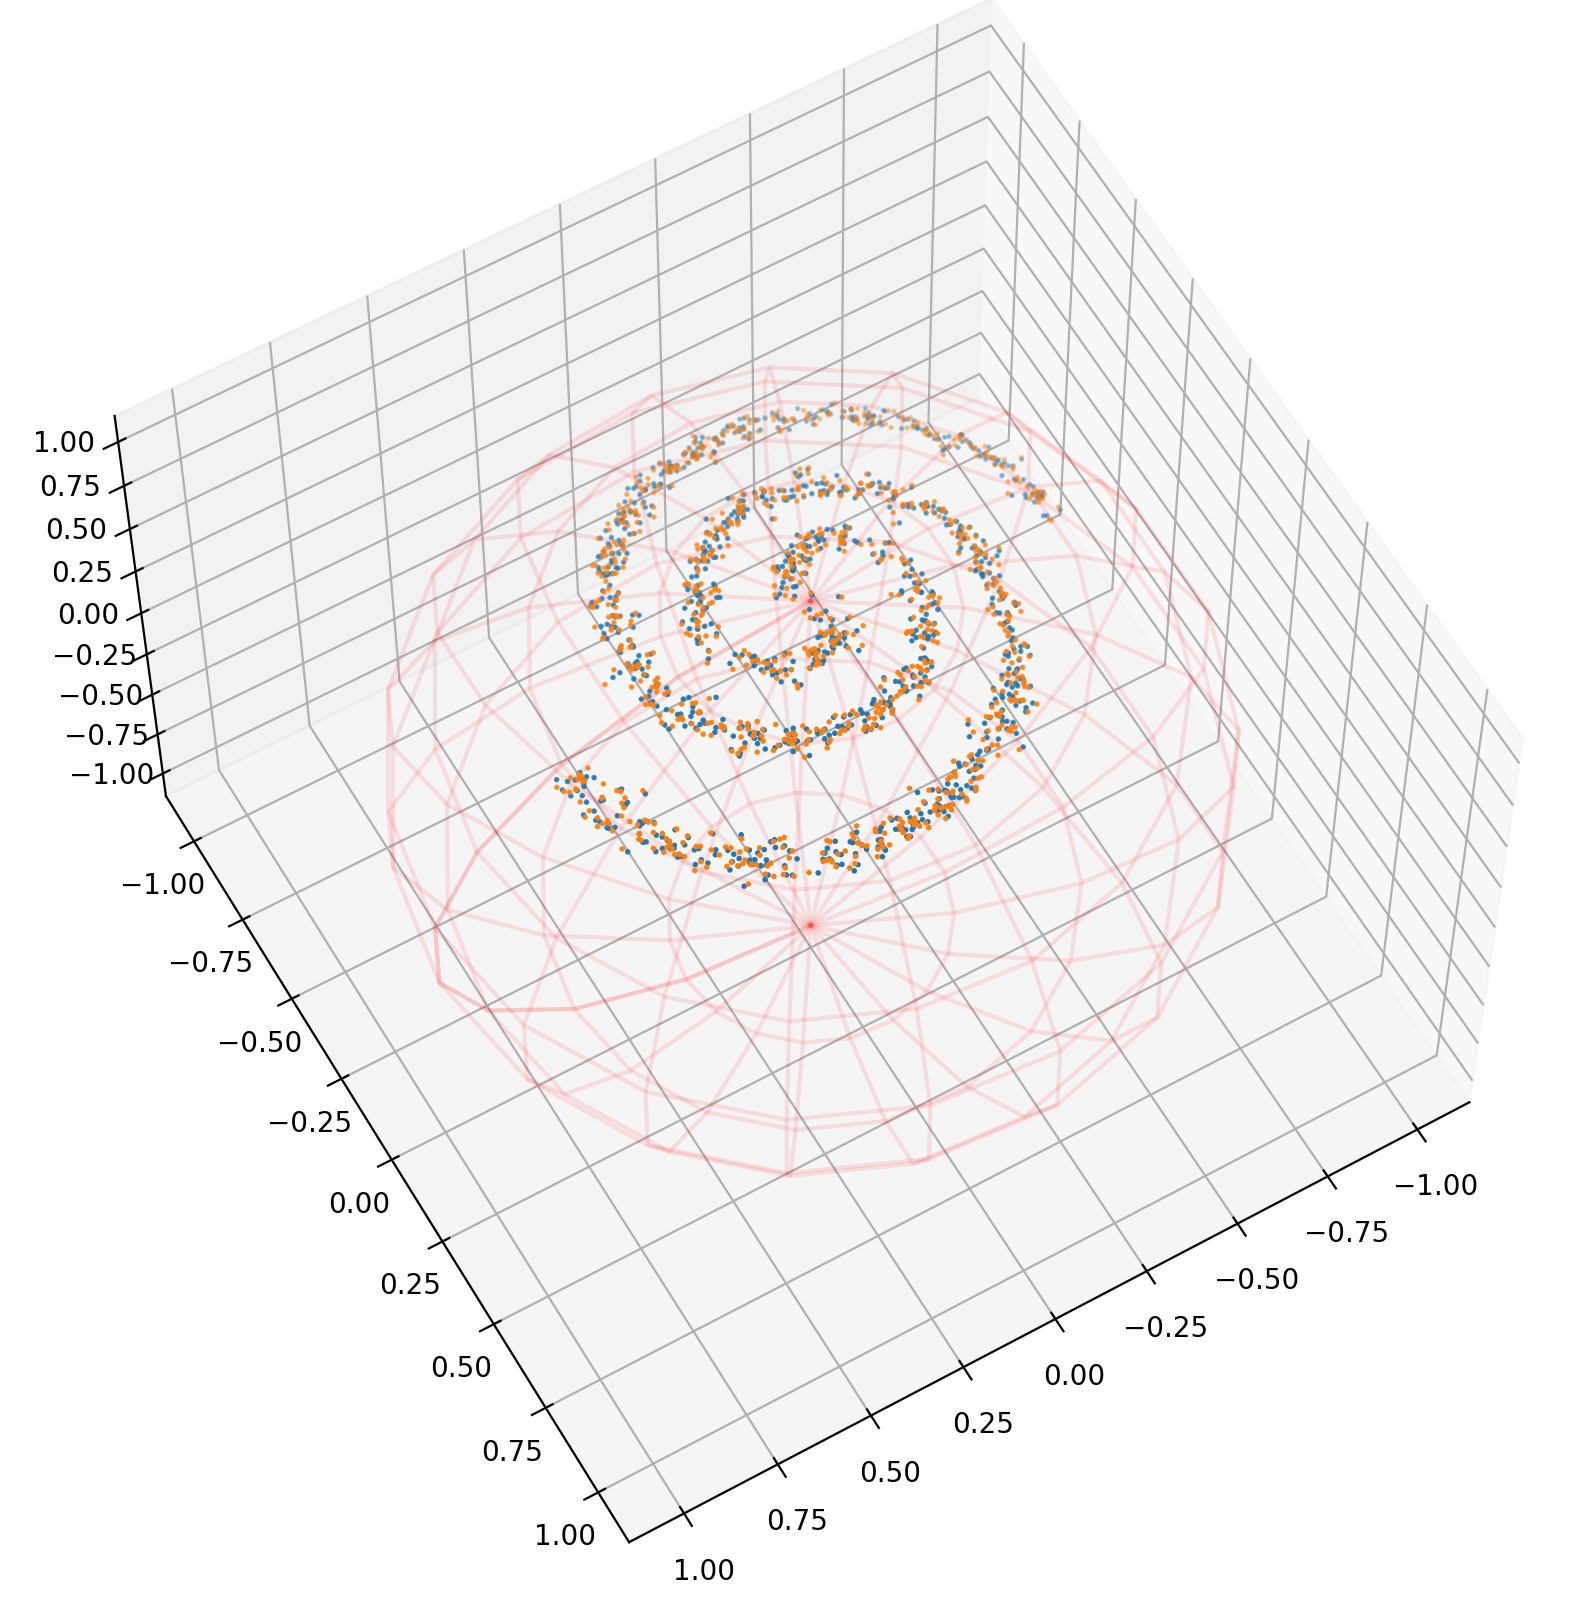

In [42]:
x = sample_2d(args.dataset, 1000)
x_ = project_on_sphere(x, r=5)
noisy_x, _ = add_noise(x_, torch.ones(x.shape[0]) * args.min_noise, manifold)

# 3d plot of x_
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=1)
ax.scatter(noisy_x[:, 0], noisy_x[:, 1], noisy_x[:, 2], s=1)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)

# plot a transparent sphere of radius 1
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

# look at plot from 45 degree angle
ax.view_init(60, 60)

# savefig
plt.savefig('sphere.png', bbox_inches='tight')

plt.show()

## Model

In [16]:
class Network(nn.Module):
    ''' Wraps around a neural network and adds methods such as `save`, `load`, and `run`. '''
    def __init__(self, net_body):
        super(Network, self).__init__()
        self.net_body = net_body

    def save(self, path, log=True):
        torch.save(self.state_dict(), path)
        if log:
            print('Saved model to `%s`' % path)

    def load(self, path, log=True, **kwargs):
        self.load_state_dict(torch.load(path, **kwargs))
        if log:
            print('Loaded model from `%s`' % path)

    def get_device(self):
        '''
        Returns the `torch.device` on which the network resides.
        This method only makes sense when all module parameters reside on the **same** device.
        '''
        return list(self.parameters())[0].device

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def forward(self, *args, **kwargs):
        return self.net_body(*args, **kwargs)


if args.dataset == 'mnist':
    class EnergyNet(nn.Module):
        def __init__(self, in_channels, act_fn=F.silu):
            super().__init__()
            self.act_fn = act_fn
            self.conv1 = nn.Conv2d(in_channels, 6, 5)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.pool = nn.AvgPool2d(2, 2)
            self.fc1 = nn.Linear(16 * 4 * 4, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 1)

        def forward(self, x):
            x = self.pool(self.act_fn(self.conv1(x)))
            x = self.pool(self.act_fn(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = self.act_fn(self.fc1(x))
            x = self.act_fn(self.fc2(x))
            x = self.fc3(x)
            return x

    net = Network(EnergyNet(in_channels=1)).to(args.device)
else:
    # class EnergyNet(nn.Module):
    #     def __init__(self, in_width, act_fn=F.silu):
    #         super().__init__()
    #         self.act_fn = act_fn
    #         self.fc_list = nn.ModuleList([
    #             nn.Linear(in_width + 1, 300),
    #             nn.Linear(300, 300),
    #             nn.Linear(300, 1)
    #         ])

    #     def forward(self, x, t):
    #         x = torch.concat([x, t[:, None]], dim=1)
    #         depth = len(self.fc_list)
    #         for i in range(depth):
    #             x = self.fc_list[i](x)
    #             x = self.act_fn(x) if i < depth - 1 else x
    #         return x

    # net = Network(EnergyNet(in_width=2)).to(args.device)

    class EnergyNet(nn.Module):
        def __init__(self, in_width, act_fn=F.relu):
            super().__init__()
            self.act_fn = act_fn
            self.fc_list = nn.ModuleList([
                nn.Linear(in_width, 300, bias=False),
                nn.Linear(300, 300, bias=False),
                nn.Linear(300, 1, bias=False)
            ])

        def forward(self, x, t):
            x_in = x
            # x = torch.concat([x, t[:, None]], dim=1)
            depth = len(self.fc_list)
            for i in range(depth):
                x = self.fc_list[i](x)
                x = self.act_fn(x) if i < depth - 1 else x
            return x / torch.norm(x_in, dim=1, keepdim=True)

    net = Network(EnergyNet(in_width=3)).to(args.device)

## Visualization

In [17]:
def plot_energy(ax, net, t):
    from numpy import arange
    from pylab import meshgrid, cm, imshow, colorbar, title, show
    x = arange(-5.0, 5.0, 0.1)
    y = arange(-5.0, 5.0, 0.1)
    k = x.shape[0]
    X, Y = meshgrid(x, y)
    data = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32, device=args.device)
        t_tensor = torch.ones(data.shape[0], device=args.device) * t
        Z = net(data, t_tensor).cpu().numpy().reshape(k, k)
    im = ax.imshow(Z, cmap=cm.RdBu, extent=[-5, 5, -5, 5], origin='lower')
    ax.set_title('Estimated Energy (t=%.2f)' % t)

## Training

In [12]:
optimizer = optim.Adam(net.parameters(), lr=args.lr)

In [13]:
!rm -rf figs_progress
!mkdir figs_progress

loss_list = []
# plotlosses = PlotLosses()

progress = tqdm(range(args.epochs), desc='Loss: None', total=args.epochs, position=0, leave=True)
for epoch in progress:
    cnt = 0
    running_loss = 0.0
    for x in train_loader:
        if args.dataset == 'mnist':
            x = x[0]
        x = x.to(args.device)
        x = project_on_sphere(x, r=5)

        # t = args.min_noise + (args.max_noise - args.min_noise) * torch.rand(x.shape[0], device=args.device)
        t = torch.ones(x.shape[0], device=args.device) * args.min_noise

        noisy_x, noise = add_noise(x, noise_strengths=t, manifold=args.manifold)

        noisy_x = noisy_x.requires_grad_()
        energy_pred = net(noisy_x, t)
        score = -torch.autograd.grad(energy_pred.sum(), noisy_x, create_graph=True)[0]

        loss = torch.sum((score + noise / (t[:, None] ** 2)) ** 2) / (2 * args.batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnt += 1
        running_loss += loss.item()

    loss_list.append(running_loss / cnt)
    progress.set_description(f'Loss: {loss_list[-1]:.4f}')
    net.save('ebm_%s_%s.tar' % (args.manifold, args.dataset))

    # fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    # plot_energy(ax[0], net, args.min_noise)
    # plot_energy(ax[1], net, (args.min_noise + args.max_noise) / 2)
    # plot_energy(ax[2], net, args.max_noise)
    # fig.savefig(path.join('figs_progress', 'energy_%03d.png' % epoch), bbox_inches='tight', dpi=200)
    # plt.show()

    # plotlosses.update({
    #     'score loss': loss_list[-1],
    #     'noise loss': loss_noise_list[-1],
    #     'total loss': loss_list[-1] + loss_noise_list[-1]
    # })
    # plotlosses.send()
    # sleep(0.5)

Loss: 8982.7078:  10%|█         | 1/10 [00:03<00:30,  3.44s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8927.7756:  20%|██        | 2/10 [00:06<00:23,  2.99s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8994.5412:  30%|███       | 3/10 [00:08<00:20,  2.86s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8961.1758:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8993.7093:  50%|█████     | 5/10 [00:14<00:13,  2.76s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8977.4941:  60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8965.5473:  70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8974.0544:  80%|████████  | 8/10 [00:22<00:05,  2.67s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8995.5550:  90%|█████████ | 9/10 [00:24<00:02,  2.58s/it]

Saved model to `ebm_sphere_2spirals.tar`


Loss: 8964.4728: 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]

Saved model to `ebm_sphere_2spirals.tar`


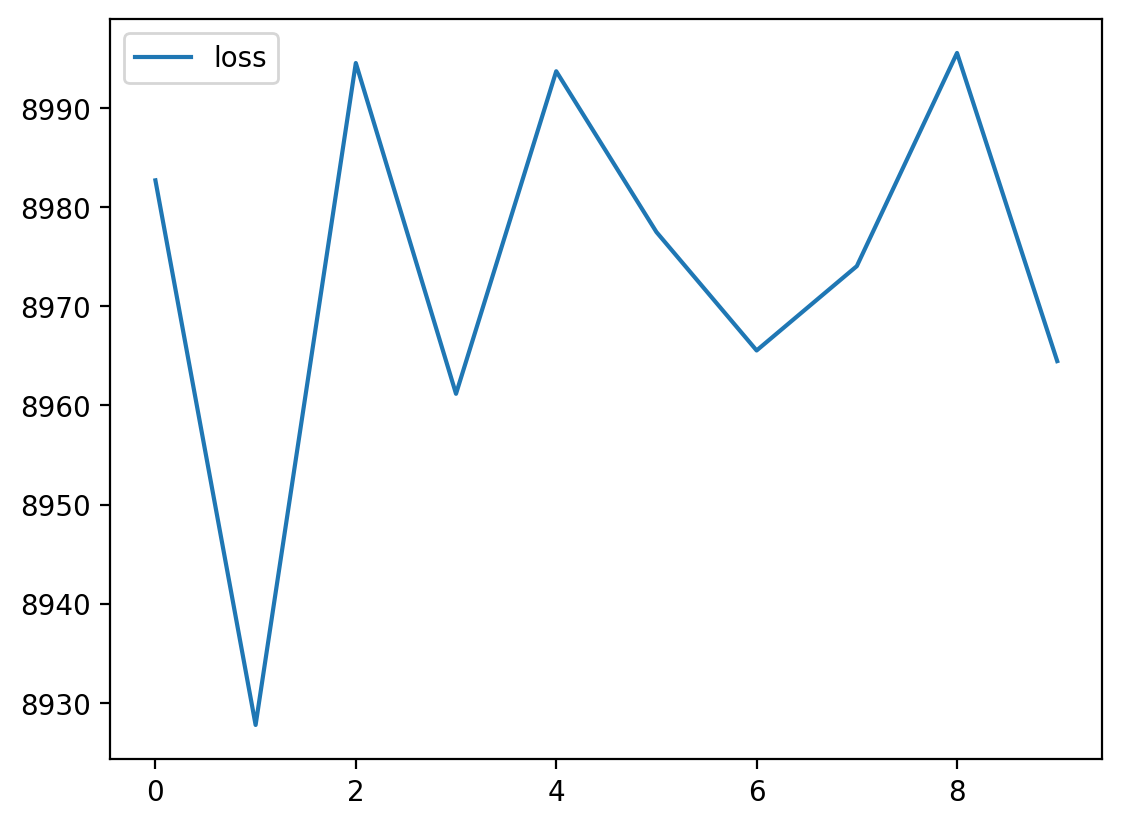

In [17]:
plt.plot(loss_list, label='loss')
plt.legend()
plt.show()

In [15]:
image_list = []
files = sorted(glob.glob('figs_progress/*.png'))
for file in files:
    image_list.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
imageio.mimsave('ebm_training_progress_%s.gif' % args.dataset, image_list, fps=10)

## Generating

In [18]:
net.load('ebm_%s_%s.tar' % (args.manifold, args.dataset))

Loaded model from `ebm_sphere_2spirals.tar`


In [45]:
def langevin_step_logp(x_, x, t, net, step_size):
    x = x.requires_grad_()
    energy_pred = net(x, t)
    score = -torch.autograd.grad(energy_pred.sum(), x, create_graph=True)[0]
    next_dist = torch.distributions.normal.Normal(loc=x + 0.5 * step_size * score, scale=np.sqrt(step_size))
    return next_dist.log_prob(x_).sum(dim=1, keepdim=True)


def unadjusted_langevin_step(x, t, net, step_size, manifold=None):
    t = torch.ones(x.shape[0], device=x.device) * t
    x = x.requires_grad_()
    energy_pred = net(x, t)
    score = -torch.autograd.grad(energy_pred.sum(), x, create_graph=True)[0]
    step = 0.5 * step_size * score
    if manifold is not None:
        manifold.expmap(x, step)
    else:
        x = x + step
    x, _ = add_noise(x, np.sqrt(step_size), manifold)
#     x = x + 0.5 * step_size * score + np.sqrt(step_size) * torch.randn_like(x)
    return x.detach()


def metropolis_adjusted_langevin_step(x, t, net, step_size):
    t = torch.ones(x.shape[0], device=x.device) * t
    x_ = unadjusted_langevin_step(x, t, net, step_size)
    u = torch.rand((x.shape[0], 1), device=args.device)
    k = langevin_step_logp(x, x_, t, net, step_size) + net(x, t) - langevin_step_logp(x_, x, t, net, step_size) - net(x_, t)
    c = (torch.exp(k) < u) * 1.0
    x_ = c * x_ + (1 - c) * x 
    return x_.detach()


def annealed_langevin_sample(x0, t_sched, net, step_size_sched, n_steps, metropolis_adjusted=False):
    x = x0
    for step in range(n_steps):
        if metropolis_adjusted:
            x = metropolis_adjusted_langevin_step(x, t_sched(step), net, step_size_sched(step))
        else:
            x = unadjusted_langevin_step(x, t_sched(step), net, step_size_sched(step))
    return x

In [46]:
n = 1000
T = 100
L = 10
eps = 2e-3
# t_sched = lambda step: (args.min_noise / args.max_noise) ** ((step // T) / (L - 1)) * args.max_noise
t_sched = lambda step: args.max_noise / (step + 1)

x_hat = annealed_langevin_sample(
    x0=torch.zeros((n, 3), device=args.device),
    t_sched=t_sched,
    net=net,
    step_size_sched=lambda _: 0.1,  #lambda step: eps * (t_sched(step) / args.min_noise) ** 2,
    n_steps=T * L,
    metropolis_adjusted=False
).cpu().numpy()

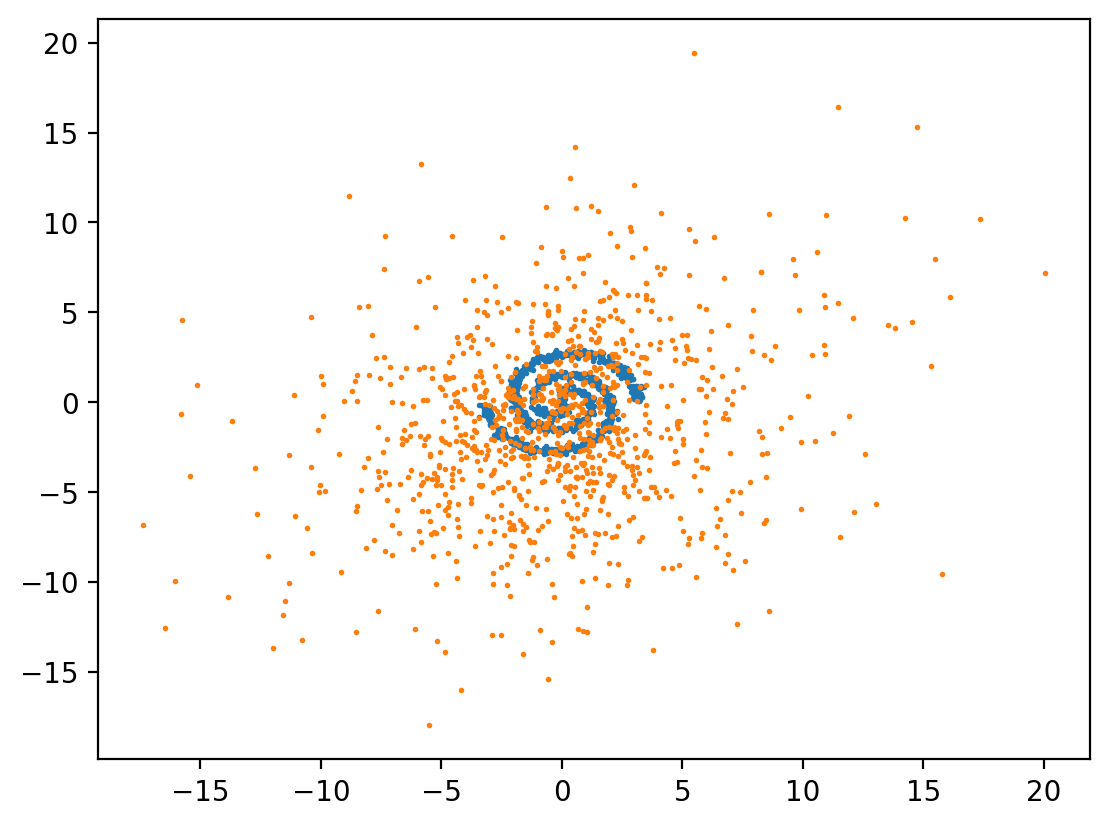

In [47]:
x = sample_2d(args.dataset, 1000)

plt.scatter(x[:, 0], x[:, 1], s=1)
plt.scatter(x_hat[:, 0], x_hat[:, 1], s=1)
plt.show()